In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# 0. import data

In [2]:
# set random state
np.random.seed(42)

In [3]:
# load data
train = pd.read_csv('/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/data/ready/train_ready.csv')
test = pd.read_csv('/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/data/ready/test_ready.csv')

In [4]:
# drop price_per_m2 from train
train = train.drop(columns=['price_per_m2'])

In [5]:
# Custom dataset class
class PropertyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [12]:
# Neural Network model
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.view(-1, 1))
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred = model(X_val)
                val_loss += criterion(y_pred, y_val.view(-1, 1)).item()
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

In [14]:
# prep data
def prepare_data(train_df):
    # Select numeric columns and target
    numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
    feature_cols = [col for col in numeric_cols if col not in ['price', 'property_id']]
    
    # Split features and target
    X = train_df[feature_cols].values
    y = train_df['price'].values
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Scale target (log transform for price)
    y_log = np.log1p(y)
    
    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y_log, test_size=0.2, random_state=42
    )
    
    # Create datasets
    train_dataset = PropertyDataset(X_train, y_train)
    val_dataset = PropertyDataset(X_val, y_val)
    
    return train_dataset, val_dataset, scaler, feature_cols

Using device: cpu
Epoch [5/50], Train Loss: 0.1871, Val Loss: 0.1670
Epoch [10/50], Train Loss: 0.1655, Val Loss: 0.1496
Epoch [15/50], Train Loss: 0.1564, Val Loss: 0.1365
Epoch [20/50], Train Loss: 0.1541, Val Loss: 0.1284
Epoch [25/50], Train Loss: 0.1512, Val Loss: 0.1378
Epoch [30/50], Train Loss: 0.1458, Val Loss: 0.1214
Epoch [35/50], Train Loss: 0.1439, Val Loss: 0.1251
Epoch [40/50], Train Loss: 0.1434, Val Loss: 0.1355
Epoch [45/50], Train Loss: 0.1415, Val Loss: 0.1282
Epoch [50/50], Train Loss: 0.1396, Val Loss: 0.1217


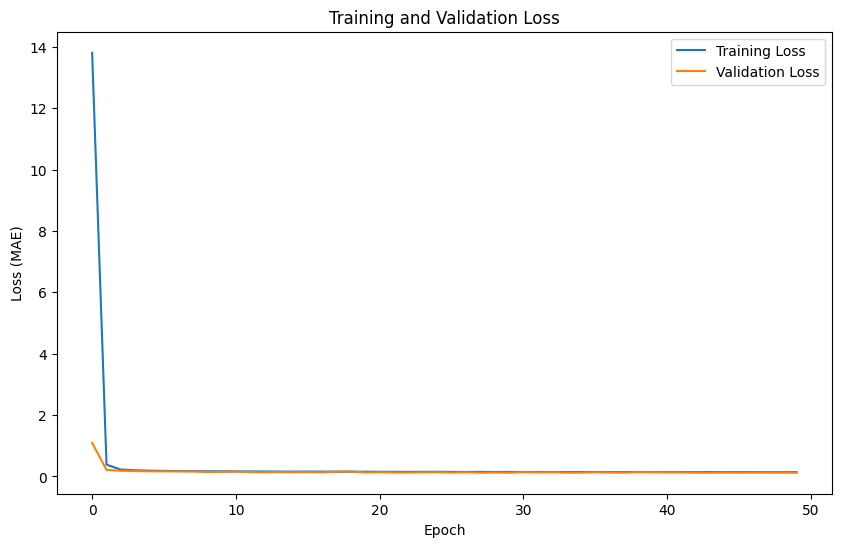

In [15]:
# main training setup
def setup_and_train(train_df, batch_size=64, num_epochs=50, learning_rate=0.001):
    # Prepare data
    train_dataset, val_dataset, scaler, feature_cols = prepare_data(train_df)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Initialize model
    model = PricePredictor(input_size=len(feature_cols)).to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()  # MAE loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, 
        optimizer, device, num_epochs
    )
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MAE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model, scaler, feature_cols

# Usage
model, scaler, feature_cols = setup_and_train(train)

In [10]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v1.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v1.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  705795392
1  45550aa81c0151f1fd9fd8fe  686527296
2  735deef3382aa15930482f3e  717641984
3  0dd49fa8bb7be52b851c6dc9  722020416
4  7d3220a91e78f8bc2924d1cd  715632704


## V2 
--> doubled neurons on first layer

In [12]:
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            # Increased first layer from 128 to 256 neurons
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            # Rest of the architecture remains the same
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

Using device: cpu
Epoch [5/50], Train Loss: 0.1894, Val Loss: 0.1717
Epoch [10/50], Train Loss: 0.1551, Val Loss: 0.1389
Epoch [15/50], Train Loss: 0.1458, Val Loss: 0.1315
Epoch [20/50], Train Loss: 0.1449, Val Loss: 0.1262
Epoch [25/50], Train Loss: 0.1376, Val Loss: 0.1234
Epoch [30/50], Train Loss: 0.1332, Val Loss: 0.1319
Epoch [35/50], Train Loss: 0.1327, Val Loss: 0.1435
Epoch [40/50], Train Loss: 0.1295, Val Loss: 0.1156
Epoch [45/50], Train Loss: 0.1293, Val Loss: 0.1146
Epoch [50/50], Train Loss: 0.1280, Val Loss: 0.1393


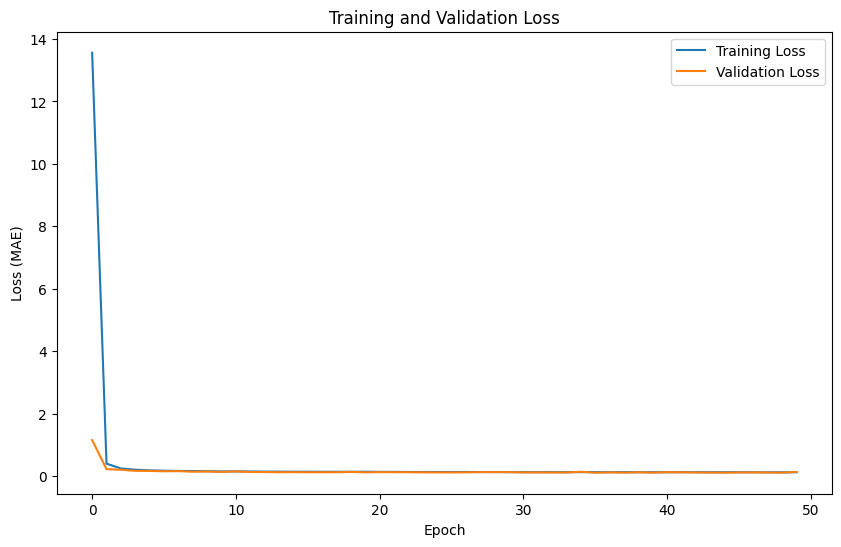

In [13]:
model, scaler, feature_cols = setup_and_train(train)

In [14]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v2.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v2.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  585912256
1  45550aa81c0151f1fd9fd8fe  584077952
2  735deef3382aa15930482f3e  632434432
3  0dd49fa8bb7be52b851c6dc9  618517440
4  7d3220a91e78f8bc2924d1cd  620445760


## v3 – LeakyReLU

In [9]:
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.1),  
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

Using device: cpu
Epoch [5/50], Train Loss: 0.1900, Val Loss: 0.1701
Epoch [10/50], Train Loss: 0.1633, Val Loss: 0.1375
Epoch [15/50], Train Loss: 0.1509, Val Loss: 0.1344
Epoch [20/50], Train Loss: 0.1443, Val Loss: 0.1300
Epoch [25/50], Train Loss: 0.1423, Val Loss: 0.1311
Epoch [30/50], Train Loss: 0.1388, Val Loss: 0.1250
Epoch [35/50], Train Loss: 0.1384, Val Loss: 0.1349
Epoch [40/50], Train Loss: 0.1340, Val Loss: 0.1397
Epoch [45/50], Train Loss: 0.1332, Val Loss: 0.1325
Epoch [50/50], Train Loss: 0.1337, Val Loss: 0.1297


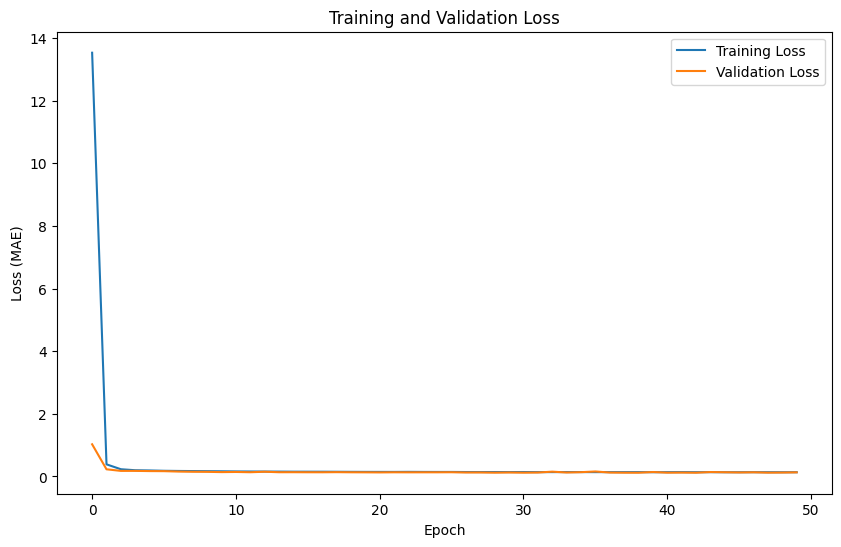

In [16]:
model, scaler, feature_cols = setup_and_train(train)

In [17]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v3.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v3.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  693523712
1  45550aa81c0151f1fd9fd8fe  606891008
2  735deef3382aa15930482f3e  731020544
3  0dd49fa8bb7be52b851c6dc9  729302016
4  7d3220a91e78f8bc2924d1cd  711028544


In [ ]:
# best-to-date

## v4 – residual connections

Residual connections allow the network to preserve and propagate subtle features more directly

In [18]:
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        # Initial projection to get to our desired width
        self.input_projection = nn.Linear(input_size, 128)
        
        # Main network layers
        self.layer1 = nn.Sequential(
            nn.Linear(128, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(32)
        )
        
        self.output = nn.Linear(32, 1)
    
    def forward(self, x):
        # Initial projection
        x = self.input_projection(x)
        
        # First residual block
        identity = x
        x = self.layer1(x)
        x = x + identity  # Residual connection
        
        # Rest of the network
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output(x)
        return x

Using device: cpu
Epoch [5/50], Train Loss: 0.1888, Val Loss: 0.1674
Epoch [10/50], Train Loss: 0.1655, Val Loss: 0.1495
Epoch [15/50], Train Loss: 0.1558, Val Loss: 0.1539
Epoch [20/50], Train Loss: 0.1465, Val Loss: 0.1389
Epoch [25/50], Train Loss: 0.1431, Val Loss: 0.1340
Epoch [30/50], Train Loss: 0.1378, Val Loss: 0.1224
Epoch [35/50], Train Loss: 0.1364, Val Loss: 0.1356
Epoch [40/50], Train Loss: 0.1351, Val Loss: 0.1249
Epoch [45/50], Train Loss: 0.1321, Val Loss: 0.1277
Epoch [50/50], Train Loss: 0.1326, Val Loss: 0.1218


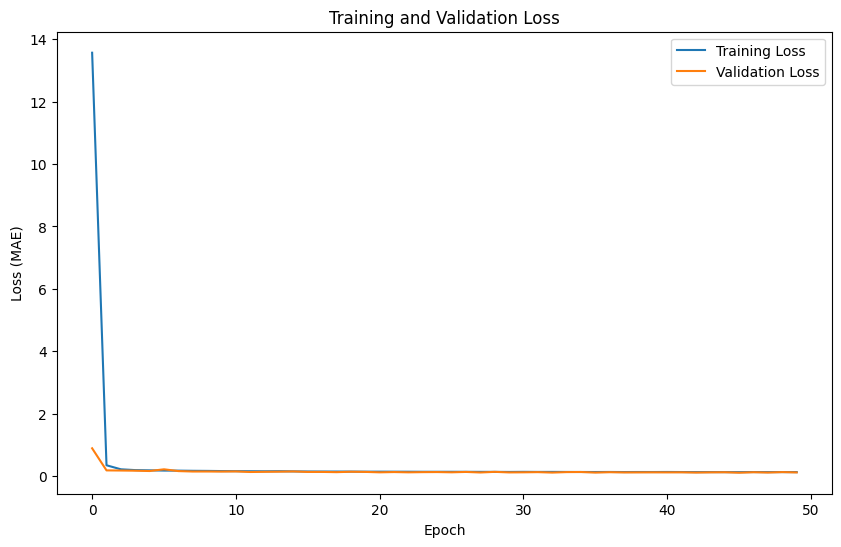

In [19]:
model, scaler, feature_cols = setup_and_train(train)

In [20]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v4.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v4.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  698835136
1  45550aa81c0151f1fd9fd8fe  635904704
2  735deef3382aa15930482f3e  712352064
3  0dd49fa8bb7be52b851c6dc9  716273152
4  7d3220a91e78f8bc2924d1cd  694524480


In [ ]:
## did not improve

### TODO
- [ ] Adjust the LeakyReLU slope (try 0.05 or 0.01)
- [ ] train for more epochs
- [ ] parallel paths w/ different activation f's
- [ ] adjust $\eta$ scheduler

### v5 – $\eta$ scheduler

In [22]:
# load v3 model (b2d)

class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.1),  
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)


In [23]:
def setup_and_train(train_df, batch_size=64, num_epochs=50, learning_rate=0.001):
    # Prepare data
    train_dataset, val_dataset, scaler, feature_cols = prepare_data(train_df)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Initialize model
    model = PricePredictor(input_size=len(feature_cols)).to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()  # MAE loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )
    
    # Train model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, 
        optimizer, scheduler, device, num_epochs
    )
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MAE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model, scaler, feature_cols

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.view(-1, 1))
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred = model(X_val)
                val_loss += criterion(y_pred, y_val.view(-1, 1)).item()
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        # Step the scheduler based on validation loss
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

Using device: cpu


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [5/50], Train Loss: 0.1856, Val Loss: 0.1549
Epoch [10/50], Train Loss: 0.1608, Val Loss: 0.1560
Epoch [15/50], Train Loss: 0.1529, Val Loss: 0.1374
Epoch [20/50], Train Loss: 0.1454, Val Loss: 0.1251
Epoch [25/50], Train Loss: 0.1426, Val Loss: 0.1295
Epoch [30/50], Train Loss: 0.1402, Val Loss: 0.1266
Epoch [35/50], Train Loss: 0.1338, Val Loss: 0.1180
Epoch [40/50], Train Loss: 0.1325, Val Loss: 0.1173
Epoch [45/50], Train Loss: 0.1302, Val Loss: 0.1214
Epoch [50/50], Train Loss: 0.1286, Val Loss: 0.1208


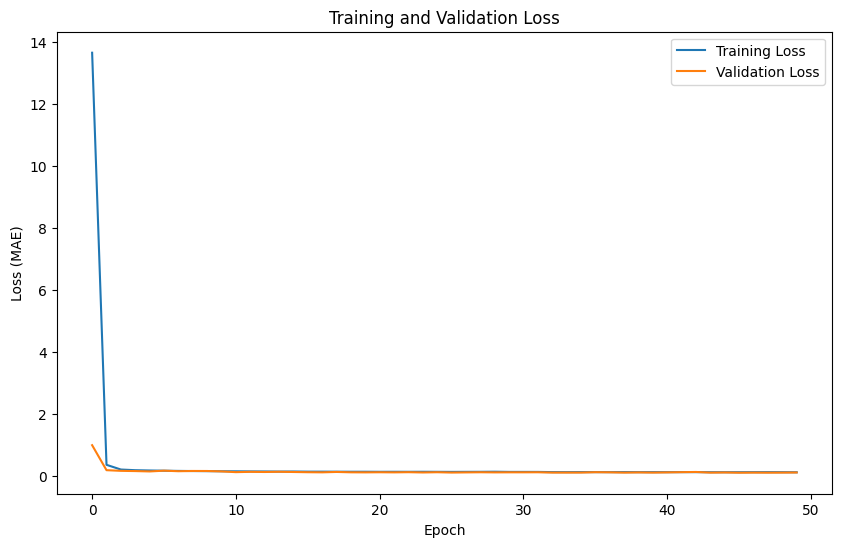

In [25]:
model, scaler, feature_cols = setup_and_train(train)

In [26]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v5.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v5.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  669358784
1  45550aa81c0151f1fd9fd8fe  640354560
2  735deef3382aa15930482f3e  685587712
3  0dd49fa8bb7be52b851c6dc9  708787584
4  7d3220a91e78f8bc2924d1cd  694675520


### TODO
- [ ] Adjust the LeakyReLU slope (try 0.05 or 0.01)
- [ ] train for more epochs
- [ ] parallel paths w/ different activation f's

### v6 – more training
* same as v3 but train for longer

In [ ]:
class PricePredictor(nn.Module):
    def __init__(self, input_size):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.1),  
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)
model, scaler, feature_cols = setup_and_train(train)

In [16]:
# main training setup
def setup_and_train(train_df, batch_size=64, num_epochs=200, learning_rate=0.001):
    # Prepare data
    train_dataset, val_dataset, scaler, feature_cols = prepare_data(train_df)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Initialize model
    model = PricePredictor(input_size=len(feature_cols)).to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()  # MAE loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, 
        optimizer, device, num_epochs
    )
    
    return model, scaler, feature_cols

# Usage
model, scaler, feature_cols = setup_and_train(train)

Using device: cpu
Epoch [5/200], Train Loss: 0.2026, Val Loss: 0.1687
Epoch [10/200], Train Loss: 0.1693, Val Loss: 0.1433
Epoch [15/200], Train Loss: 0.1577, Val Loss: 0.1567
Epoch [20/200], Train Loss: 0.1499, Val Loss: 0.1579
Epoch [25/200], Train Loss: 0.1419, Val Loss: 0.1299
Epoch [30/200], Train Loss: 0.1383, Val Loss: 0.1243
Epoch [35/200], Train Loss: 0.1342, Val Loss: 0.1247
Epoch [40/200], Train Loss: 0.1332, Val Loss: 0.1205
Epoch [45/200], Train Loss: 0.1313, Val Loss: 0.1267
Epoch [50/200], Train Loss: 0.1286, Val Loss: 0.1219
Epoch [55/200], Train Loss: 0.1275, Val Loss: 0.1200
Epoch [60/200], Train Loss: 0.1285, Val Loss: 0.1174
Epoch [65/200], Train Loss: 0.1246, Val Loss: 0.1533
Epoch [70/200], Train Loss: 0.1255, Val Loss: 0.1382
Epoch [75/200], Train Loss: 0.1249, Val Loss: 0.1311
Epoch [80/200], Train Loss: 0.1220, Val Loss: 0.1099
Epoch [85/200], Train Loss: 0.1249, Val Loss: 0.1116
Epoch [90/200], Train Loss: 0.1229, Val Loss: 0.1167
Epoch [95/200], Train Loss: 0

In [17]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v6.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v6.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  570397632
1  45550aa81c0151f1fd9fd8fe  535011776
2  735deef3382aa15930482f3e  751395584
3  0dd49fa8bb7be52b851c6dc9  580986880
4  7d3220a91e78f8bc2924d1cd  719444224


## v7 
* same as v3 but with different leaky relu slope

In [26]:
class PricePredictor(nn.Module):
    def __init__(self, input_size, leaky_slope=0.1):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(negative_slope=leaky_slope),  
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope=leaky_slope), 
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(negative_slope=leaky_slope), 
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        return self.network(x)

In [27]:
def setup_and_train(train_df, batch_size=64, num_epochs=50, learning_rate=0.001, leaky_slope=0.1):
    # Prepare data
    train_dataset, val_dataset, scaler, feature_cols = prepare_data(train_df)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Initialize model with configurable leaky slope
    model = PricePredictor(input_size=len(feature_cols), leaky_slope=leaky_slope).to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()  # MAE loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, 
        optimizer, device, num_epochs
    )
    
    return model, scaler, feature_cols

In [28]:
model, scaler, feature_cols = setup_and_train(train, leaky_slope=0.2)  # changed ReLU slope to 0.2

Using device: cpu
Epoch [5/50], Train Loss: 0.2025, Val Loss: 0.1644
Epoch [10/50], Train Loss: 0.1714, Val Loss: 0.1659
Epoch [15/50], Train Loss: 0.1604, Val Loss: 0.1366
Epoch [20/50], Train Loss: 0.1569, Val Loss: 0.1364
Epoch [25/50], Train Loss: 0.1485, Val Loss: 0.1359
Epoch [30/50], Train Loss: 0.1458, Val Loss: 0.1404
Epoch [35/50], Train Loss: 0.1458, Val Loss: 0.1408
Epoch [40/50], Train Loss: 0.1412, Val Loss: 0.1286
Epoch [45/50], Train Loss: 0.1401, Val Loss: 0.1204
Epoch [50/50], Train Loss: 0.1377, Val Loss: 0.1254


In [29]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v7.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale with clipping
    predictions = np.expm1(y_pred_log).flatten()
    
    # Handle infinite values and extremes
    max_reasonable_price = 1e9  # 1 billion - adjust this based on your domain knowledge
    min_reasonable_price = 1e4  # 10,000 - adjust this based on your domain knowledge
    
    # Clip predictions to reasonable range
    predictions = np.clip(predictions, min_reasonable_price, max_reasonable_price)
    
    # Replace any remaining infinities or NaNs with the mean of valid predictions
    valid_predictions = predictions[np.isfinite(predictions)]
    if len(valid_predictions) > 0:
        predictions[~np.isfinite(predictions)] = np.mean(valid_predictions)
    else:
        predictions[~np.isfinite(predictions)] = max_reasonable_price/2
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())

    return submission

# submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v7.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  641933312
1  45550aa81c0151f1fd9fd8fe  580654528
2  735deef3382aa15930482f3e  681881472
3  0dd49fa8bb7be52b851c6dc9  664102912
4  7d3220a91e78f8bc2924d1cd  688288128


# v8
* working off v3 but now implementing parallel paths w/ different activation f's

In [34]:
class ParallelPricePredictor(nn.Module):
    def __init__(self, input_size):
        super(ParallelPricePredictor, self).__init__()
        
        # Path 1: LeakyReLU path (original)
        self.path1 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(32)
        )
        
        # Path 2: ELU path
        self.path2 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ELU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ELU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ELU(),
            nn.BatchNorm1d(32)
        )
        
        # Path 3: GELU path
        self.path3 = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.GELU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.GELU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.GELU(),
            nn.BatchNorm1d(32)
        )
        
        # Combine paths - starting with same size as original final layer
        self.combine = nn.Sequential(
            nn.Linear(32 * 3, 64),  # Concatenated output from three paths
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        # Process each path
        out1 = self.path1(x)
        out2 = self.path2(x)
        out3 = self.path3(x)
        
        # Concatenate the outputs
        combined = torch.cat((out1, out2, out3), dim=1)
        
        # Final processing
        return self.combine(combined).squeeze(-1)

In [35]:
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            
            # Ensure target dimension matches prediction
            if len(y_batch.shape) == 1:
                y_batch = y_batch.view(-1)
            if len(y_pred.shape) == 1:
                y_pred = y_pred.view(-1)
                
            loss = criterion(y_pred, y_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                y_pred = model(X_batch)
                
                # Ensure target dimension matches prediction
                if len(y_batch.shape) == 1:
                    y_batch = y_batch.view(-1)
                if len(y_pred.shape) == 1:
                    y_pred = y_pred.view(-1)
                    
                val_loss += criterion(y_pred, y_batch).item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            model.load_state_dict(best_model_state)
            break
    
    return train_losses, val_losses

In [36]:
def setup_and_train(train_df, batch_size=64, num_epochs=50, learning_rate=0.001):
    # Prepare data
    train_dataset, val_dataset, scaler, feature_cols = prepare_data(train_df)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Initialize model
    model = ParallelPricePredictor(input_size=len(feature_cols)).to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()  # MAE loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Train model with early stopping
    train_losses, val_losses = train_model_with_early_stopping(
        model, train_loader, val_loader, criterion, 
        optimizer, scheduler, device, num_epochs,
        patience=10  # Early stopping patience
    )
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MAE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model, scaler, feature_cols

Using device: cpu


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 9.5129, Val Loss: 0.7514
Epoch [6/50], Train Loss: 0.2032, Val Loss: 0.1724
Epoch [11/50], Train Loss: 0.1777, Val Loss: 0.1508
Epoch [16/50], Train Loss: 0.1629, Val Loss: 0.1436
Epoch [21/50], Train Loss: 0.1540, Val Loss: 0.1276
Epoch [26/50], Train Loss: 0.1476, Val Loss: 0.1293
Epoch [31/50], Train Loss: 0.1376, Val Loss: 0.1199
Epoch [36/50], Train Loss: 0.1356, Val Loss: 0.1300
Epoch [41/50], Train Loss: 0.1328, Val Loss: 0.1226
Epoch [46/50], Train Loss: 0.1288, Val Loss: 0.1233
Early stopping triggered after epoch 47


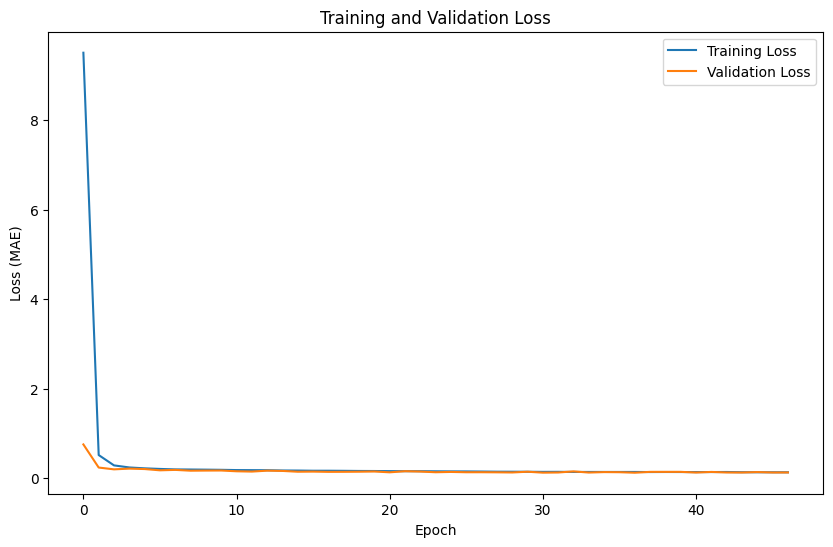

In [37]:
model, scaler, feature_cols = setup_and_train(train)

In [38]:
def create_submission_file(model, test_df, scaler, feature_cols, filename='/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v8.csv'):
    """
    Create submission file with predictions in the required format
    """
    # Prepare test data
    X_test = test_df[feature_cols].values
    X_test_scaled = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make predictions
    with torch.no_grad():
        y_pred_log = model(X_test_tensor).cpu().numpy()
    
    # Convert from log space back to original scale
    predictions = np.expm1(y_pred_log).flatten()
    
    # Create submission DataFrame
    submission = pd.DataFrame({
        'property_id': test_df['property_id'],
        'price': predictions
    })
    
    # Round prices to integers
    submission['price'] = submission['price'].round().astype(int)
    
    # Save to CSV with the exact format
    submission.to_csv(filename, index=False, quoting=1)  # quoting=1 ensures quotes around property_id
    
    print(f"\nSubmission file created: {filename}")
    print(f"Number of predictions: {len(submission)}")
    print("\nSample of submission file:")
    print(submission.head())
    
    return submission

# Create submission
submission = create_submission_file(model, test, scaler, feature_cols)


Submission file created: /Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/nn_v8.csv
Number of predictions: 10286

Sample of submission file:
                property_id      price
0  d56159653f5d2abc5ed5acd7  635790720
1  45550aa81c0151f1fd9fd8fe  610750976
2  735deef3382aa15930482f3e  748227776
3  0dd49fa8bb7be52b851c6dc9  652182848
4  7d3220a91e78f8bc2924d1cd  670717248


## Grid Search

In [46]:
class PricePredictor(nn.Module):
    def __init__(self, input_size, hidden_size1=128, hidden_size2=64, dropout1=0.3, dropout2=0.2):
        super(PricePredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.LeakyReLU(0.1),  
            nn.BatchNorm1d(hidden_size1),
            nn.Dropout(dropout1),
            
            nn.Linear(hidden_size1, hidden_size2),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(hidden_size2),
            nn.Dropout(dropout2),
            
            nn.Linear(hidden_size2, 32),
            nn.LeakyReLU(0.1), 
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

In [54]:
import itertools
import copy

def grid_search(train_df, param_grid):
    """
    Perform grid search over specified hyperparameters.
    """
    results = []
    best_val_loss = float('inf')
    best_model = None
    best_scaler = None
    best_features = None
    best_params = None
    
    # First get the feature columns to ensure consistent input size
    _, _, _, feature_cols = prepare_data(train_df)
    input_size = len(feature_cols)
    
    # Generate all combinations of parameters
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    param_combinations = list(itertools.product(*values))
    
    total_combinations = len(param_combinations)
    print(f"Total parameter combinations to try: {total_combinations}")
    print(f"Input size: {input_size}")
    
    for i, params in enumerate(param_combinations, 1):
        current_params = dict(zip(keys, params))
        print(f"\nTrying combination {i}/{total_combinations}")
        print("Parameters:", current_params)
        
        # Create model with current parameters
        try:
            model = PricePredictor(
                input_size=input_size,  # Use correct input size
                hidden_size1=current_params['hidden_size1'],
                hidden_size2=current_params['hidden_size2'],
                dropout1=current_params['dropout1'],
                dropout2=current_params['dropout2']
            )
            
            # Train model
            model, scaler, feature_cols, train_losses, val_losses = train_model_with_tracking(
                train_df,
                model,
                batch_size=current_params['batch_size'],
                learning_rate=current_params['learning_rate'],
                num_epochs=50
            )
            
            # Calculate average validation loss over last 5 epochs
            avg_val_loss = np.mean(val_losses[-5:])
            min_val_loss = np.min(val_losses)
            
            # Store results
            result = {
                'params': current_params,
                'avg_val_loss': avg_val_loss,
                'min_val_loss': min_val_loss,
                'final_val_loss': val_losses[-1]
            }
            results.append(result)
            
            # Update best model if current model is better
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = copy.deepcopy(model)
                best_scaler = copy.deepcopy(scaler)
                best_features = feature_cols.copy()
                best_params = current_params.copy()
                
                print(f"\nNew best model found!")
                print(f"Average validation loss: {avg_val_loss:.4f}")
                print(f"Parameters: {best_params}")
            
        except Exception as e:
            print(f"Error with parameters {current_params}: {str(e)}")
            continue
    
    # Create DataFrame with all results
    results_df = pd.DataFrame(results)
    results_df = pd.concat([
        results_df,
        pd.json_normalize(results_df['params'])
    ], axis=1).drop('params', axis=1)
    
    # Sort by average validation loss
    results_df = results_df.sort_values('avg_val_loss')
    
    print("\nGrid Search Complete!")
    print("\nTop 5 combinations:")
    print(results_df.head())
    
    return best_params, best_model, best_scaler, best_features, results_df

In [ ]:
def train_model_with_tracking(train_df, model, batch_size, learning_rate, num_epochs):
    """
    Train model and track losses for grid search with proper tensor dimensions
    """
    # Prepare data
    train_dataset, val_dataset, scaler, feature_cols = prepare_data(train_df)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).view(-1, 1)  # reshpe target to match output
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device).view(-1, 1)  # reshape target to match output
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return model, scaler, feature_cols, train_losses, val_losses


In [56]:
# run 1
param_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [32, 64, 128],
    'dropout1': [0.2, 0.3, 0.4],
    'dropout2': [0.1, 0.2, 0.3],
    'hidden_size1': [64, 128, 256],
    'hidden_size2': [32, 64, 128]
}

best_params, best_model, best_scaler, best_features, results_df = grid_search(train, param_grid)

# Save results
results_df.to_csv('/Users/edmundoarias/Documents/Uniandes/2024-2/ProblemSet_3/results/submissions/nn/grid_search_results.csv', index=False)

print("\nBest parameters found:")
print(best_params)

Total parameter combinations to try: 729
Input size: 56

Trying combination 1/729
Parameters: {'learning_rate': 0.001, 'batch_size': 32, 'dropout1': 0.2, 'dropout2': 0.1, 'hidden_size1': 64, 'hidden_size2': 32}
Epoch [1/50], Train Loss: 6.9987, Val Loss: 0.2427
Epoch [11/50], Train Loss: 0.1630, Val Loss: 0.1548
Epoch [21/50], Train Loss: 0.1531, Val Loss: 0.1295
Epoch [31/50], Train Loss: 0.1486, Val Loss: 0.1417
Epoch [41/50], Train Loss: 0.1453, Val Loss: 0.1230

New best model found!
Average validation loss: 0.1295
Parameters: {'learning_rate': 0.001, 'batch_size': 32, 'dropout1': 0.2, 'dropout2': 0.1, 'hidden_size1': 64, 'hidden_size2': 32}

Trying combination 2/729
Parameters: {'learning_rate': 0.001, 'batch_size': 32, 'dropout1': 0.2, 'dropout2': 0.1, 'hidden_size1': 64, 'hidden_size2': 64}
Epoch [1/50], Train Loss: 6.9838, Val Loss: 0.2571
Epoch [11/50], Train Loss: 0.1578, Val Loss: 0.1378
Epoch [21/50], Train Loss: 0.1468, Val Loss: 0.1232
Epoch [31/50], Train Loss: 0.1470, V